In [406]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
from geopy.distance import vincenty
from sklearn import preprocessing
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
import numpy as np
import statsmodels.api as sm
path = "C:\\Users\\Vaibhav\\Desktop\\GoJek\\"
trainFile = "GoJek_traindata.csv"
testFile = "GoJek_testdata.csv"

## Creating Features

In [302]:
def data_processing(File):
    data = pd.read_csv(path+File,header=0,index_col = None)
    data['perc_disc'] = data['amount_cust_discount']/data['original_rate_cost']
    data['fromLoc'] = data[['booking_from_long','booking_from_lat']].apply(tuple,axis=1)
    data['toLoc'] = data[['booking_to_long','booking_to_lat']].apply(tuple,axis=1)
    data['distance'] = map(lambda x,y: vincenty(x,y).miles, data['fromLoc'],data['toLoc'])
    data['total_amt'] = data['original_rate_cost'] - data['amount_cust_discount']
    le_status = preprocessing.LabelEncoder()
    data.booking_status = le_status.fit_transform(data.booking_status)
    data.head()
    data['time'] = map(lambda x: float(x[10:].replace(":",".")), data['booking_date'])
    data['date'] = map(lambda x: (x[:9].replace(":",".")), data['booking_date'])
    data['day_time'] = 0
    data.ix[(data.time >= 0) & (data.time <= 4),'day_time']= 0
    data.ix[(data.time >= 4) & (data.time <= 8),'day_time']= 1
    data.ix[(data.time >= 8) & (data.time <= 12),'day_time']= 2
    data.ix[(data.time >= 12) & (data.time <= 16),'day_time']= 3
    data.ix[(data.time >= 16) & (data.time <= 20),'day_time']= 4
    data.ix[(data.time >= 20) & (data.time <= 24),'day_time']= 5
    data['is_frequent'] = data.groupby('customer_id')['customer_id'].transform('count')
    for cust in data[data.is_frequent ==2]['customer_id'].unique():
        time_min = data[(data.is_frequent ==2) & (data.customer_id == cust)]['time'].min()
        data.ix[(data.time == time_min) & (data.customer_id == cust) ,'is_frequent'] = 1

    for cust in data[data.is_frequent ==3]['customer_id'].unique():
        time_min = data[(data.is_frequent ==3) & (data.customer_id == cust)]['time'].min()
        data.ix[(data.time == time_min) & (data.customer_id == cust) ,'is_frequent'] = 1

    for cust in data[data.is_frequent ==3]['customer_id'].unique():
        time_min = data[(data.is_frequent ==3) & (data.customer_id == cust)]['time'].min()
        data.ix[(data.time == time_min) & (data.customer_id == cust) ,'is_frequent'] = 2

    data['final_amt'] = data['total_amt']*data['distance']
    data['intercept'] = 1.0
    #data.columns

    dataNew = data[['booking_status','intercept','is_rush_hour_price','perc_disc','distance','day_time',
                    'is_frequent','final_amt']]
    return dataNew

In [400]:
trainData = data_processing(trainFile)
testData = data_processing(testFile)

#trainDataNew.groupby('booking_status').mean().plot(kind = 'bar',figsize = (12,6))
trainData.groupby('booking_status').mean()

,intercept,is_rush_hour_price,perc_disc,distance,day_time,is_frequent,final_amt
booking_status,,,,,,,
0,1.0,0.231884,0.476257,2.738238,2.042899,1.022609,54039.395778
1,1.0,0.230602,0.496300,2.304647,1.836959,1.014866,37787.055874


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A2CCBE0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000E407EB00>]], dtype=object)

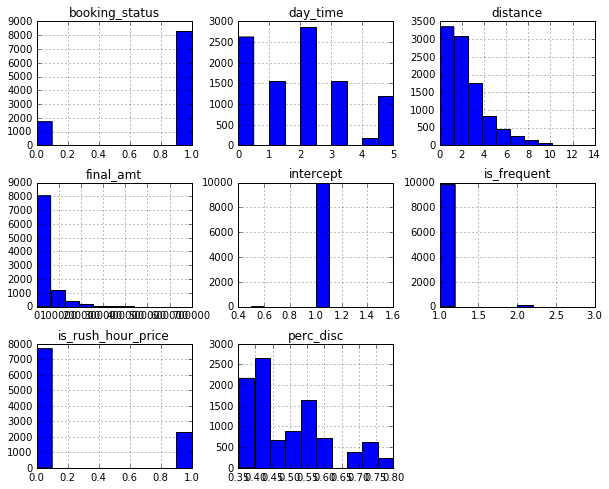

In [401]:
trainData.hist(figsize=(10,8))

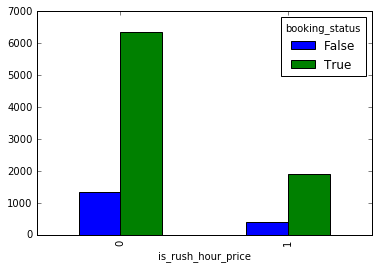

In [402]:
pd.crosstab(trainData.is_rush_hour_price, trainData.booking_status.astype(bool)).plot(kind='bar')

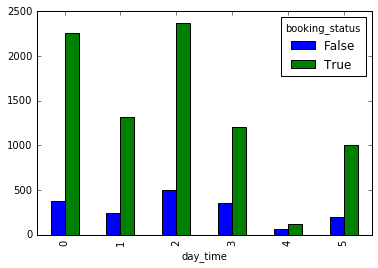

In [410]:
pd.crosstab(trainData.day_time, trainData.booking_status.astype(bool)).plot(kind='bar')

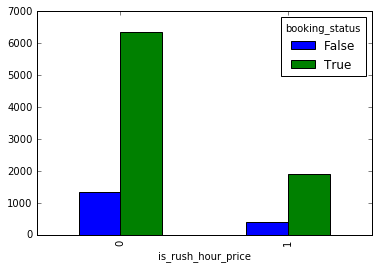

In [411]:
pd.crosstab(trainData.is_rush_hour_price, trainData.booking_status.astype(bool)).plot(kind='bar')

## Logistic Regression

In [432]:
predictors = [x for x in trainData.columns if x not in  ['booking_status','intercept','is_rush_hour_price']]
logit = sm.Logit(trainData['booking_status'], trainData[predictors])
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.453325
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                 9999
Model:                          Logit   Df Residuals:                     9994
Method:                           MLE   Df Model:                            4
Date:                Sun, 18 Sep 2016   Pseudo R-squ.:                 0.01420
Time:                        19:16:02   Log-Likelihood:                -4532.8
converged:                       True   LL-Null:                       -4598.1
                                        LLR p-value:                 2.913e-27
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
perc_disc       2.0083      0.239      8.419      0.000         1.541     2.476
distance        0.1992      0.036      5.544      0.000         0.129     0.270
day_time       -0.0648      0.017     -3.902      0.000        -0.097    -0.032
is_frequent     0.6158      0.133      4.614      0.000         0.354     0.877
final_amt   -9.267e-06   1.15e-06     -8.030      0.000     -1.15e-05    -7e-06
===============================================================================
"""

In [434]:
predicted = result.predict(testData[predictors])  
print np.mean(y_test==(predicted >=0.5))
print y_test.mean()

0.8135
0.8149


In [418]:
trainData.pivot_table(values = 'final_amt',index = ['booking_status','day_time'],aggfunc=np.mean)

booking_status  day_time
0               0           52408.707812
                1           56008.368218
                2           60410.039279
                3           49756.216862
                4           52360.929261
                5           46837.921508
1               0           36373.453625
                1           37539.981776
                2           38084.680870
                3           33779.767099
                4           40006.855712
                5           45095.931723
Name: final_amt, dtype: float64

## Random Forest Classifier

In [435]:
from sklearn.ensemble import RandomForestClassifier
train_cols = trainData.columns[2:]
rf = RandomForestClassifier(n_estimators=200,class_weight={1: 1, 0:10})
rf.fit(trainData[train_cols], trainData.booking_status)

RandomForestClassifier(bootstrap=True, class_weight={0: 10, 1: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [436]:
y = trainData.booking_status
output = rf.predict(trainData[train_cols])
np.mean(y==output)

1.0

In [437]:
y_test = testData.booking_status
output = rf.predict(testData[train_cols])
np.mean(y_test==output)

0.77190000000000003

## Gradient Boosted Classifier

In [159]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['booking_status'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['booking_status'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['booking_status'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['booking_status'], dtrain_predprob)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8343
AUC Score (Train): 0.687354
CV Score : Mean - 0.6034985 | Std - 0.006273439 | Min - 0.593899 | Max - 0.6102483


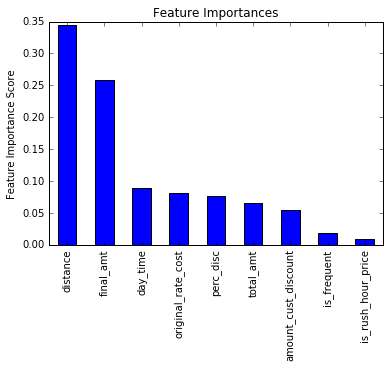

In [208]:
predictors = [x for x in trainData.columns if x not in ['booking_status','intercept']]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, trainData, predictors)

In [253]:
predictors = [x for x in trainData.columns if x not in  ['booking_status','intercept']]
param_test1 = {'n_estimators':range(20,101,20)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.01, min_samples_split=100,
                                    min_samples_leaf=50,max_depth=8,max_features='log2',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(trainData[predictors],trainData['booking_status'])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.60574, std: 0.00767, params: {'n_estimators': 20},
  mean: 0.60868, std: 0.00756, params: {'n_estimators': 40},
  mean: 0.60721, std: 0.00616, params: {'n_estimators': 60},
  mean: 0.60662, std: 0.00688, params: {'n_estimators': 80},
  mean: 0.60636, std: 0.00693, params: {'n_estimators': 100}],
 {'n_estimators': 40},
 0.60868498542423011)

In [212]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=20, 
                                                               max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(trainData[predictors],trainData['booking_status'])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.60357, std: 0.00997, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: 0.61018, std: 0.00884, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: 0.60917, std: 0.01111, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: 0.60791, std: 0.00703, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: 0.60817, std: 0.00894, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: 0.60150, std: 0.00686, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: 0.60322, std: 0.00631, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: 0.60469, std: 0.00662, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: 0.60764, std: 0.00709, params: {'min_samples_split': 800, 'max_depth': 7},
  mean: 0.60791, std: 0.00420, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: 0.60021, std: 0.01045, params: {'min_samples_split': 200, 'max_depth': 9},
  mean: 0.60423, std: 0.00593, params: {'min_samples_split': 400, 'max_depth': 9},
  

In [213]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=20,max_depth=5,max_features='sqrt', 
                                                               subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(trainData[predictors],trainData['booking_status'])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.60836, std: 0.00719, params: {'min_samples_split': 1000, 'min_samples_leaf': 30},
  mean: 0.60840, std: 0.00903, params: {'min_samples_split': 1200, 'min_samples_leaf': 30},
  mean: 0.60731, std: 0.00799, params: {'min_samples_split': 1400, 'min_samples_leaf': 30},
  mean: 0.60649, std: 0.00822, params: {'min_samples_split': 1600, 'min_samples_leaf': 30},
  mean: 0.60698, std: 0.00806, params: {'min_samples_split': 1800, 'min_samples_leaf': 30},
  mean: 0.60541, std: 0.00802, params: {'min_samples_split': 2000, 'min_samples_leaf': 30},
  mean: 0.60693, std: 0.00770, params: {'min_samples_split': 1000, 'min_samples_leaf': 40},
  mean: 0.60829, std: 0.00873, params: {'min_samples_split': 1200, 'min_samples_leaf': 40},
  mean: 0.60603, std: 0.00953, params: {'min_samples_split': 1400, 'min_samples_leaf': 40},
  mean: 0.60685, std: 0.00764, params: {'min_samples_split': 1600, 'min_samples_leaf': 40},
  mean: 0.60469, std: 0.00826, params: {'min_samples_split': 1800, 'min_samples_


Model Report
Accuracy : 0.8275
AUC Score (Train): 0.643512
CV Score : Mean - 0.6087333 | Std - 0.007282829 | Min - 0.5991287 | Max - 0.6213247


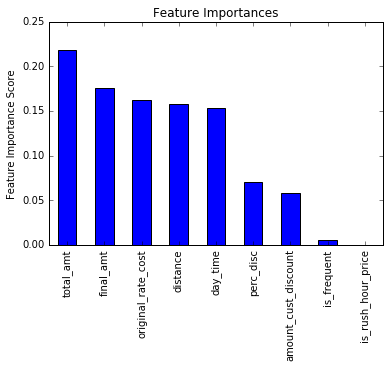

In [214]:
modelfit(gsearch3.best_estimator_, trainData, predictors)

In [218]:
param_test4 = {'max_features':range(1,9,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=20,
                                            max_depth=5, min_samples_split=1000, min_samples_leaf=60, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(trainData[predictors],trainData['booking_status'])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.59993, std: 0.00513, params: {'max_features': 1},
  mean: 0.60157, std: 0.00562, params: {'max_features': 2},
  mean: 0.60873, std: 0.00728, params: {'max_features': 3},
  mean: 0.60717, std: 0.00664, params: {'max_features': 4},
  mean: 0.60881, std: 0.00511, params: {'max_features': 5},
  mean: 0.61101, std: 0.00580, params: {'max_features': 6},
  mean: 0.60854, std: 0.00634, params: {'max_features': 7},
  mean: 0.60846, std: 0.00792, params: {'max_features': 8}],
 {'max_features': 6},
 0.61100535852327942)

In [219]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=20,max_depth=5,
                                        min_samples_split=1000, min_samples_leaf=60, subsample=0.8, random_state=10,max_features=6),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(trainData[predictors],trainData['booking_status'])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.60814, std: 0.00568, params: {'subsample': 0.6},
  mean: 0.60662, std: 0.00501, params: {'subsample': 0.7},
  mean: 0.60863, std: 0.00636, params: {'subsample': 0.75},
  mean: 0.61101, std: 0.00580, params: {'subsample': 0.8},
  mean: 0.60808, std: 0.00378, params: {'subsample': 0.85},
  mean: 0.60952, std: 0.00402, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.61100535852327942)


Model Report
Accuracy : 0.8317
AUC Score (Train): 0.713875


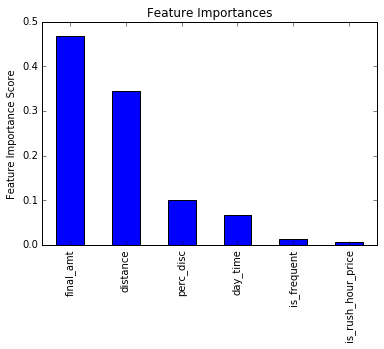

In [308]:
predictors = [x for x in trainData.columns if x not in  ['booking_status','intercept']]
gbm_tuned_4 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1500,max_depth=9, min_samples_split=1200, 
                                         min_samples_leaf=60, subsample=0.85, random_state=10, max_features=6,
warm_start=True)
modelfit(gbm_tuned_4, trainData, predictors, performCV=False)

In [309]:
#predictors = [x for x in trainData.columns if x not in  ['booking_status','intercept']]
y_test = testData.booking_status
output = gbm_tuned_4.predict(testData[predictors])
np.mean(y_test==output)

0.8135

## Multiple Random Forest with random sampling

In [440]:
from sklearn.ensemble import RandomForestClassifier
#for s in range(1,101,10):
predictors = [x for x in trainData.columns if x not in  ['booking_status','intercept']]
y_test = testData.booking_status
outList = list()
y_0 = trainData[trainData.booking_status == 0]
y_1 = trainData[trainData.booking_status == 1]
n = min([len(y_0),len(y_1)])
for s in range(1,101,1):
    y_0 = y_0.sample(n=n,random_state=s)
    y_1 = y_1.sample(n=n,random_state=s)
    trainStrat = pd.concat([y_0,y_1])
    X_strat = trainStrat[predictors]
    y_strat = trainStrat.booking_status

    rf = RandomForestClassifier(n_estimators=200)
    rf.fit(X_strat, y_strat)

   
    output = rf.predict(testData[predictors])
    outList.append(output)

In [441]:
#from scipy.stats import mode
preds = pd.DataFrame(mode(pd.DataFrame(outList))[0]).iloc[0]

np.mean(y_test==preds)
#np.mean(y_test==preds[0])


0.52170000000000005

In [438]:
from sklearn.cross_validation import StratifiedShuffleSplit
predictors = [x for x in trainData.columns if x not in  ['booking_status','intercept']]
sss = StratifiedShuffleSplit(trainData.booking_status, 100, random_state=0)
outList = list()
y_test = testData.booking_status
trainDataNew = np.array(trainData[predictors])
for train_index, test_index in sss:
    X_train = trainDataNew[train_index]
    y_train = trainData.booking_status[train_index]
    rf = RandomForestClassifier(n_estimators=200)
    rf.fit(X_train, y_train)
    output = rf.predict(testData[predictors])
    outList.append(output)
    


In [439]:
#from scipy.stats import mode
preds = pd.DataFrame(mode(pd.DataFrame(outList))[0]).iloc[0]

np.mean(y_test==preds)
#np.mean(y_test==preds[0])


0.77010000000000001